# Relationships using expression distance

This notebook is performing the same analysis as seen in [all_gene_relationships.ipynb](all_gene_relationships.ipynb), where we are examining who is related to who. Previously we started with an accessory gene and asked: is the highest correlated gene another accessory gene or a core gene? For this analysis, we are starting with the most stable core genes and asking the same question: is the highest correlated gene core or accessory?

Note: We do not have the genome location metric here because this would require a significant effort to figure out how to modify the existing code to only focus on a subset of genes.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scripts import utils, paths, gene_relationships, annotations

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
method = "affinity"
offset_to_bin = 10

use_operon = True
sum_increment_to_use = 1

# Output filename
pao1_figure_filename = "PAO1_stablility_expression_relationships_operon_corrected.svg"
pa14_figure_filename = "PA14_stability_expression_relationships_operon_corrected.svg"

### Import gene ids

In [3]:
# Import correlation matrix to get gene ids
pao1_corr_filename = paths.PAO1_CORR_RAW
pa14_corr_filename = paths.PA14_CORR_RAW

pao1_corr = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pa14_corr = pd.read_csv(pa14_corr_filename, sep="\t", index_col=0, header=0)

In [4]:
# Make a dataframe with gene ids
pao1_membership = pd.DataFrame(data=[], index=pao1_corr.index)
print(pao1_membership.shape)
pao1_membership.head()

(5563, 0)


""
PA0001
PA0002
PA0003
PA0004
PA0005


In [5]:
pa14_membership = pd.DataFrame(data=[], index=pa14_corr.index)
print(pa14_membership.shape)
pa14_membership.head()

(5891, 0)


""
PA14_55610
PA14_55600
PA14_55590
PA14_55580
PA14_55570


### Import and format operon data

In [6]:
pao1_operon_filename = paths.PAO1_OPERON
pa14_operon_filename = paths.PA14_OPERON

In [7]:
# pao1_operon = pd.read_csv(pao1_operon_filename, index_col=0, header=0)
# pa14_operon = pd.read_csv(pa14_operon_filename, index_col=0, header=0)

In [8]:
# pao1_operon.head()

,operon_name,locus_tag,start,end,strand,gene_name,source_database,pmid
operon-id,,,,,,,,
operon-1,dnaA-dnaN-recF-gyrB,PA0001,483,2027,1,dnaA,DOOR,18988623
operon-1,dnaA-dnaN-recF-gyrB,PA0002,2056,3159,1,dnaN,DOOR,18988623
operon-1,dnaA-dnaN-recF-gyrB,PA0003,3169,4278,1,recF,DOOR,18988623
operon-1,dnaA-dnaN-recF-gyrB,PA0004,4275,6695,1,gyrB,DOOR,18988623
operon-2,PA0006-lptA,PA0005,7018,7791,-1,lptA,DOOR,18988623


In [9]:
# pao1_operon = pao1_operon.set_index("locus_tag")
# pa14_operon = pa14_operon.set_index("locus_tag")

In [10]:
# print(pao1_operon.shape)
# pao1_operon.head()

(3816, 7)


,operon_name,start,end,strand,gene_name,source_database,pmid
locus_tag,,,,,,,
PA0001,dnaA-dnaN-recF-gyrB,483,2027,1,dnaA,DOOR,18988623
PA0002,dnaA-dnaN-recF-gyrB,2056,3159,1,dnaN,DOOR,18988623
PA0003,dnaA-dnaN-recF-gyrB,3169,4278,1,recF,DOOR,18988623
PA0004,dnaA-dnaN-recF-gyrB,4275,6695,1,gyrB,DOOR,18988623
PA0005,PA0006-lptA,7018,7791,-1,lptA,DOOR,18988623


In [11]:
# There are 247 PAO1 genes with multiple annotations
# This operon df contains annotations from predicted operons based on DOOR database
# predictions which make up the majority of the operons) as well as some that
# are curated (i.e. PseudoCAP)
# There are some that have multiple PseudoCAP annotations too

# Here we will keep the last PseudoCAP annotations
# Note: Do we want to discard these annotations all together
# or will these need to be carefully curated to determine which to keep?
# We will use the curated annotation here
# pao1_operon = pao1_operon[~pao1_operon.index.duplicated(keep="last")]
# pa14_operon = pa14_operon[~pa14_operon.index.duplicated(keep="last")]

In [12]:
# pao1_operon.head()

,operon_name,start,end,strand,gene_name,source_database,pmid
locus_tag,,,,,,,
PA0001,dnaA-dnaN-recF-gyrB,483,2027,1,dnaA,DOOR,18988623
PA0002,dnaA-dnaN-recF-gyrB,2056,3159,1,dnaN,DOOR,18988623
PA0003,dnaA-dnaN-recF-gyrB,3169,4278,1,recF,DOOR,18988623
PA0004,dnaA-dnaN-recF-gyrB,4275,6695,1,gyrB,DOOR,18988623
PA0005,PA0006-lptA,7018,7791,-1,lptA,DOOR,18988623


In [13]:
# Only include columns for gene id and operon_name
# pao1_operon = pao1_operon["operon_name"].to_frame()
# pa14_operon = pa14_operon["operon_name"].to_frame()

In [ ]:
pao1_operon = annotations.load_format_operons(pao1_operon_filename)
pa14_operon = annotations.load_format_operons(pa14_operon_filename)

In [14]:
print(pao1_operon.shape)
pao1_operon.head()

(3569, 1)


,operon_name
locus_tag,
PA0001,dnaA-dnaN-recF-gyrB
PA0002,dnaA-dnaN-recF-gyrB
PA0003,dnaA-dnaN-recF-gyrB
PA0004,dnaA-dnaN-recF-gyrB
PA0005,PA0006-lptA


In [15]:
if use_operon:
    pao1_operon_expression_to_use = pao1_operon
    pa14_operon_expression_to_use = pa14_operon
else:
    pao1_operon_expression_to_use = None
    pa14_operon_expression_to_use = None

### Map core/accessory labels to genes

In [16]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

# pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
# pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

In [17]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

# core_acc_dict = utils.get_my_core_acc_genes(
#    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
# )

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5357
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 534


In [18]:
# pao1_core = core_acc_dict["core_pao1"]
# pa14_core = core_acc_dict["core_pa14"]
# pao1_acc = core_acc_dict["acc_pao1"]
# pa14_acc = core_acc_dict["acc_pa14"]

In [19]:
# pao1_membership.loc[pao1_core, "core/acc"] = "core"
# pao1_membership.loc[pao1_acc, "core/acc"] = "acc"

In [20]:
# pa14_acc_shared = set(pa14_acc).intersection(pa14_gene_module_labels.index)
# pa14_membership.loc[pa14_core, "core/acc"] = "core"
# pa14_membership.loc[pa14_acc, "core/acc"] = "acc"

In [ ]:
pao1_arr, pa14_arr = annotations.map_core_acc_annot(
    pao1_membership,
    pa14_membership,
    pao1_expression_filename,
    pa14_expression_filename,
    pao1_annot_filename,
    pa14_annot_filename,
)

In [21]:
# Drop "module id" column
# TO DO: rename
# pao1_arr = pao1_membership
# pa14_arr = pa14_membership

In [22]:
# Make sure to sort by gene id
# NOTE PA14 gene ids don't increment by 1, but by 10 or 20 are we missing some genes?
# pao1_arr = pao1_arr.sort_index()
# pa14_arr = pa14_arr.sort_index()

In [23]:
print(pao1_arr.shape)
pao1_arr.head()

(5563, 1)


,core/acc
PA0001,core
PA0002,core
PA0003,core
PA0004,core
PA0005,core


In [24]:
pao1_arr.tail()

,core/acc
PA5566,core
PA5567,core
PA5568,core
PA5569,core
PA5570,acc


In [25]:
print(pa14_arr.shape)
pa14_arr.head()

(5891, 1)


,core/acc
PA0263.1,acc
PA0263.2,acc
PA0263.3,acc
PA14_00010,core
PA14_00020,core


In [26]:
pa14_arr.tail()

,core/acc
PA14_73390,core
PA14_73400,core
PA14_73410,core
PA14_73420,core
PA2170.1,acc


In [27]:
# Fill in index of operon_df to include all genes
all_pao1_gene_ids = pao1_arr.index
all_pa14_gene_ids = pa14_arr.index

# Get missing gene ids
missing_pao1_gene_ids = set(all_pao1_gene_ids).difference(pao1_operon.index)
missing_pa14_gene_ids = set(all_pa14_gene_ids).difference(pa14_operon.index)

# Make dataframe with missing gene ids with np.nan values for operon_name
missing_pao1_gene_df = pd.DataFrame(
    data=np.nan, index=list(missing_pao1_gene_ids), columns=["operon_name"]
)
missing_pa14_gene_df = pd.DataFrame(
    data=np.nan, index=list(missing_pa14_gene_ids), columns=["operon_name"]
)

pao1_operon_genome_dist = pao1_operon.append(missing_pao1_gene_df)
pa14_operon_genome_dist = pa14_operon.append(missing_pa14_gene_df)

pao1_operon_genome_dist = pao1_operon_genome_dist.loc[all_pao1_gene_ids]
pa14_operon_genome_dist = pa14_operon_genome_dist.loc[all_pa14_gene_ids]

In [28]:
print(pao1_operon_genome_dist.shape)
pao1_operon_genome_dist.tail()

(5563, 1)


,operon_name
PA5566,NaN
PA5567,PA5568-PA5567
PA5568,PA5568-PA5567
PA5569,rpmH-rnpA
PA5570,rpmH-rnpA


In [29]:
print(pa14_operon_genome_dist.shape)
pa14_operon_genome_dist.tail()

(5891, 1)


,operon_name
PA14_73390,NaN
PA14_73400,PA14_73410-trmE
PA14_73410,PA14_73410-trmE
PA14_73420,NaN
PA2170.1,NaN


In [30]:
if use_operon:
    pao1_operon_genome_to_use = pao1_operon_genome_dist
    pa14_operon_genome_to_use = pa14_operon_genome_dist
else:
    pao1_operon_genome_to_use = None
    pa14_operon_genome_to_use = None

## Find relationships using expression distance

In [31]:
# Correlation matrix files
pao1_corr_filename = paths.PAO1_CORR_LOG_SPELL
pa14_corr_filename = paths.PA14_CORR_LOG_SPELL

In [32]:
# Load correlation data
pao1_corr = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pa14_corr = pd.read_csv(pa14_corr_filename, sep="\t", index_col=0, header=0)

In [33]:
# Load transcriptional similarity df
# These are the subset of genes that we will consider
pao1_similarity_scores_filename = "../core_core_analysis/pao1_similarity_scores.tsv"
pa14_similarity_scores_filename = "../core_core_analysis/pa14_similarity_scores.tsv"

pao1_similarity_scores = pd.read_csv(
    pao1_similarity_scores_filename, sep="\t", header=0, index_col=0
)
pa14_similarity_scores = pd.read_csv(
    pa14_similarity_scores_filename, sep="\t", header=0, index_col=0
)

In [34]:
# Get most and least stable core genes
pao1_most_stable_genes = list(
    pao1_similarity_scores[pao1_similarity_scores["label"] == "most stable"].index
)
pao1_least_stable_genes = list(
    pao1_similarity_scores[pao1_similarity_scores["label"] == "least stable"].index
)

pa14_most_stable_genes = list(
    pa14_similarity_scores[pa14_similarity_scores["label"] == "most stable"].index
)
pa14_least_stable_genes = list(
    pa14_similarity_scores[pa14_similarity_scores["label"] == "least stable"].index
)

In [36]:
%%time
expression_dist_counts_pao1_most = (
    gene_relationships.get_relationship_in_expression_space(
        pao1_corr,
        pao1_most_stable_genes,
        pao1_arr,
        offset_to_bin,
        pao1_operon_expression_to_use,
        sum_increment_to_use,
    )
)
expression_dist_counts_pao1_least = (
    gene_relationships.get_relationship_in_expression_space(
        pao1_corr,
        pao1_least_stable_genes,
        pao1_arr,
        offset_to_bin,
        pao1_operon_expression_to_use,
        sum_increment_to_use,
    )
)

CPU times: user 8min 56s, sys: 154 ms, total: 8min 56s
Wall time: 8min 56s


In [37]:
%%time
expression_dist_counts_pa14_most = (
    gene_relationships.get_relationship_in_expression_space(
        pa14_corr,
        pa14_most_stable_genes,
        pa14_arr,
        offset_to_bin,
        pa14_operon_expression_to_use,
        sum_increment_to_use,
    )
)
expression_dist_counts_pa14_least = (
    gene_relationships.get_relationship_in_expression_space(
        pa14_corr,
        pa14_least_stable_genes,
        pa14_arr,
        offset_to_bin,
        pa14_operon_expression_to_use,
        sum_increment_to_use,
    )
)

CPU times: user 9min 32s, sys: 1.16 s, total: 9min 33s
Wall time: 9min 33s


In [38]:
expression_dist_counts_pao1_most.head()

,offset,gene type,total
0,1,acc,1.0
1,2,acc,2.0
2,3,acc,2.0
3,4,acc,2.0
4,5,acc,3.0


In [39]:
expression_dist_counts_pao1_least.head()

,offset,gene type,total
0,1,acc,17.0
1,2,acc,19.0
2,3,acc,16.0
3,4,acc,22.0
4,5,acc,19.0


In [40]:
expression_dist_counts_pa14_most.head()

,offset,gene type,total
0,1,acc,2.0
1,2,acc,5.0
2,3,acc,6.0
3,4,acc,5.0
4,5,acc,6.0


In [41]:
expression_dist_counts_pa14_least.head()

,offset,gene type,total
0,1,acc,31.0
1,2,acc,37.0
2,3,acc,27.0
3,4,acc,25.0
4,5,acc,31.0


### Plot

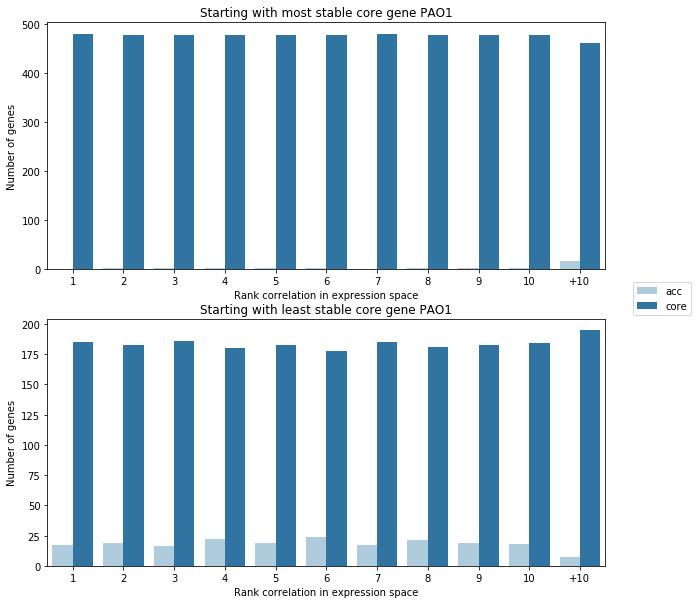

In [42]:
# Plot PAO1 trends
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 10))

fig = sns.barplot(
    data=expression_dist_counts_pao1_most,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes[0],
    palette=sns.color_palette("Paired"),
)
fig.legend_.remove()
fig.set_title("Starting with most stable core gene PAO1")
fig.set_ylabel("Number of genes")
fig.set_xlabel("Rank correlation in expression space")

fig = sns.barplot(
    data=expression_dist_counts_pao1_least,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes[1],
    palette=sns.color_palette("Paired"),
)
fig.legend_.remove()
fig.set_title("Starting with least stable core gene PAO1")
fig.set_ylabel("Number of genes")
fig.set_xlabel("Rank correlation in expression space")


# Note: We are creating a single global legend that apply
# to all the facets of this figure. To do this using
# matplotlib, we need to be a little creative here
# and add the legend to a new location that is applied
# to the figure and then remove the legend from the facet.
plt.legend(bbox_to_anchor=(1.05, 1.15), loc=2, borderaxespad=0.0)

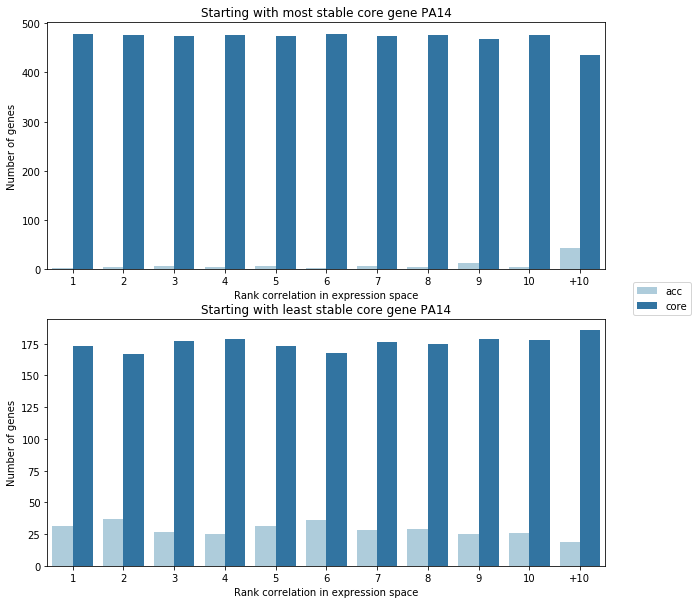

In [43]:
# Plot PA14 trends
fig2, axes2 = plt.subplots(ncols=1, nrows=2, figsize=(10, 10))

fig2 = sns.barplot(
    data=expression_dist_counts_pa14_most,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes2[0],
    palette=sns.color_palette("Paired"),
)
fig2.legend_.remove()
fig2.set_title("Starting with most stable core gene PA14")
fig2.set_ylabel("Number of genes")
fig2.set_xlabel("Rank correlation in expression space")

fig2 = sns.barplot(
    data=expression_dist_counts_pa14_least,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes2[1],
    palette=sns.color_palette("Paired"),
)
fig2.legend_.remove()
fig2.set_title("Starting with least stable core gene PA14")
fig2.set_ylabel("Number of genes")
fig2.set_xlabel("Rank correlation in expression space")

plt.legend(bbox_to_anchor=(1.05, 1.15), loc=2, borderaxespad=0.0)

In [44]:
# Save figures using operons*
# Save figures not using operons*
# Save figure with rolling sum and operons
# Save figure with rolling sum not using operons
fig.figure.savefig(
    pao1_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

fig2.figure.savefig(
    pa14_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**

* Least stable core genes have more accessory gene neighbors compared to most stable core genes
* Maybe these least stable genes are late core genes (i.e. acquired recently)? Maybe these least stable core genes transcriptional behavior is modified by the accessory genes.